In [1]:
import numpy as np
import pandas
from fractions import Fraction
from matplotlib import pyplot as plt
from numpy import linalg as LA

# HW4-Adaptive control of the RK method

## Part0: Problem set


* Implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.
* You can use the Bogacki-Shampine method or any other method with an embedded error estimate.
* A step should be rejected if the local truncation error exceeds the tolerance.
* Test your method on the nonlinear equation
$$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$
for $k=2$, $k=5$, and $k=20$.
* Make a work-precision diagram for your adaptive method and for constant step sizes.
* State your conclusions or ideas (in a README, or Jupyter notebook) about appropriate (efficient, accurate, reliable) methods for this type of problem.

## Part1: Discretization with error estimate embedded

The first method to be used is the Bogacki-Shampine method. For a given time step size $h$ and first order differential equation $y'= f(t,y)$, it is a Runge-Kutta method with global order $3$ and stage $4$. In addition, the forth stage is an embedded second-order evalution which will be executed per time step such that an adaptive control could be implemented during the computation. <br>

The Bogacki-Shampine method$^{[1]}$ of time step $t_{n+1}$ as: <br>
$$\begin{split}
K_1 &= f(t_n,y_n) \\
K_2 &= f(t_n+\frac{1}{2}h_n,y_n + \frac{1}{2}h_n K_1) \\
K_3 &= f(t_n+\frac{3}{4}h_n,y_n + \frac{3}{4}h_n K_2) \\
K_4 &= f(t_n+h_n,y_{n+1}) \\
\end{split}$$

where <br> 
$$y_{n+1} = y_n + \frac{4}{9}h_n(\frac{1}{2}K_1 + \frac{3}{4}K_2 + K3)$$
And the second-order evaluation as: <br>
$$z_{n+1} = y_n + \frac{1}{3}h_n(\frac{7}{8}K_1 + \frac{3}{4}K_2 + K_3 + \frac{3}{8}K_4)$$ <br>

In adaptive control, we choose $\epsilon = 10^{-5}$ and if the local truncation error $e_{\text{loc}}(h) = \lVert h (b - \tilde b)^T f(Y) \rVert$ exceeds the $\epsilon$, we reject the current time step and compute it again by decreasing the time step size as $h = 0.8 h_*$, for a given method order $p$, the $h_*$ is computed by: $$ h_* = \left( \frac{\epsilon}{e_{\text{loc}}(h) / h^p} \right)^{1/p} . $$

Futhermore, in adaptive method, if a time step size is rejected once, then for the Bogacki-Shampine method, 3 more function evaluations is needed. Thus, when counting the total function evaluations for the adaptive method, additional function evaluations $\text{f_eval}$ should be added to the total number. <br>

The code for constructing the adaptive method as:

In [2]:
'''the code of this homework is based on the FDTransient notebook in the
   class and some changes has been made
'''
def BS3_bct():        # the Butcher Table of Bogacki-Shampine method
    A = np.array    ([[0, 0, 0, 0],
                     [1/2, 0, 0, 0],
                     [0, 3/4, 0, 0],
                     [2/9, 1/3, 4/9, 0]])    #table of coefficients
    
    b = np.array    ([[2/9, 1/3, 4/9, 0],
                     [7/24, 1/4, 1/3, 1/8]]) # vector of completion weights
    return A, b[0,:], b[1,:]                 # one for solving, one for error control


def RHS(t,u,k):                                  #the RHS funciton, independent of t
        return np.array([[u[1]], [k*(1-u[0]**2)*u[1] - u[0]]])
    

def adp_RK(u0, BT, tfinal, h, k, p, e, apt):  #u0 is the initial value , p is the order of the method, e is the tolerence
    A, b1, b2 = BT
    c = np.sum(A, axis=1)      # vector of abscissa
    s = len(c)                 # number of stages
    u   = u0.copy()
    u_e = u0.copy()            # initialize the error control vector
    t = 0
    hist = [(t,u0)]            # the initial status pair
    
    f_eval = 0                 # to count the additional function evaluations in the adaptive control
    
    ########__decide the final step size__########
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
    ##############################################

        fY = np.zeros((len(u0), s))                  #the approximation matrix at t = t + h, col for each stage
        for i in range(s):                           # i = 0,1,2...s-1
            Yi = u.copy() 
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = RHS(t + h*c[i], Yi, k).ravel()
        
        if apt==False:                              # for uniform time steps
            u += h * fY @ b1
            t = tnext
            hist.append((t, u.copy()))
    
             
        else:                                       # for adaptive time steps
            e_loc =  LA.norm (h * fY @ (b1-b2), np.inf)
            c_loc  =  e_loc/(h**p)
            h_star =  np.power(e/c_loc,1/p)
            #print(e_loc-e,h,t)
            if (e_loc>=e) and (h_star>=0.001):
                h = h_star* 0.8                                    # Safe factor  =  0.8
                f_eval = f_eval + 3                                # if a step is rejected, 3 more evals needed
                        
            else:
                u     += h * fY @ b1
                t = tnext
                hist.append((t, u.copy())) 
                
    #print(f_eval)    
    return hist, f_eval

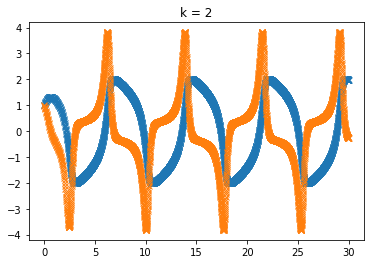

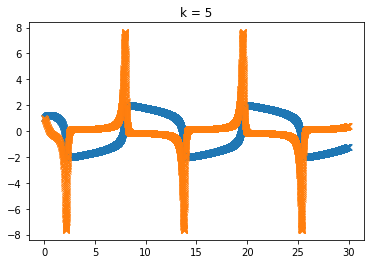

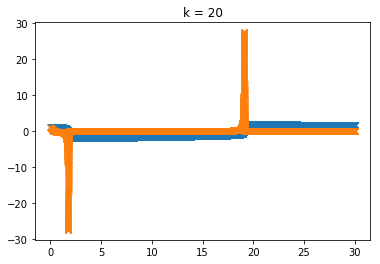

In [3]:
for k in [2,5,20]:
    u0 =  np.array([1.0, 1.0])                   # the initial value
    h  = 0.1                                     # the time step size
    hist,f_eval = adp_RK(u0, BS3_bct(), 30, h, k, 3, 0.00001, True)
######____plotting___#########
    plt.figure()
    times = [t for t,u in hist]
    plt.plot(times, [u for t,u in hist], 'x')
    plt.title("k = " + str(k))
    

## Part2: Higher order study

In this section, the second numerical method studied is the Runge–Kutta–Fehlberg method$^{[2]}$, a 6-stage, fifth-order technique with error estimate embedded as well. The Butcher table of this method is defined as: <br>

$$ \left[ \begin{array}{c|cccccc}
0 & 0 & 0 & 0 & 0 &0 &0\\
\frac 1 4 & \frac 1 4 & 0 & 0 & 0 & 0 &0 \\
\frac 3 8 & \frac 3 {32} & \frac 9 {32} & 0 & 0 & 0 &0\\
\frac {12} {13} & \frac {1932}{2197} & \frac{-7200}{2197} & \frac{7296}{2197} & 0 & 0 &0 \\
1 & \frac {439}{216} & -8 & \frac{3680}{513} & \frac{-845}{4104} & 0 &0\\
\frac {1} {2} & \frac {-8}{27} & 2 & \frac{-3544}{2565} & \frac{1859}{4104} & \frac{-11}{40} &0\\
\hline
A: & \frac {16} {135} & 0 & \frac {6656} {12825} & \frac {28561} {56430} &\frac{-9}{50}   &\frac{2}{55}\\
B: & \frac {25} {216} & 0 & \frac {1408} {2565} & \frac {2797} {4104} &\frac{-1}{5}   &0
\end{array} \right] . $$ <br>
where A and B lead to the accuracy order of $5$ and $4$, respectively. <br>
<br>
The code for constructing the Runge–Kutta–Fehlberg method with adaptive step control embedded as:

In [4]:
def RKF():
    dframe = pandas.read_html('https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method')[0]
# Clean up unicode minus sign, NaN, and convert to float
    dfloat = dframe.applymap(lambda s: s.replace('−', '-') if isinstance(s, str) else s) \
        .fillna(0).applymap(Fraction).astype(float)

# Extract the Butcher table
    darray = np.array(dfloat)
    A_RKF = darray[:6,2:]
    b_RKF = darray[6:,2:]
    return A_RKF , b_RKF[0,:] , b_RKF[1,:]

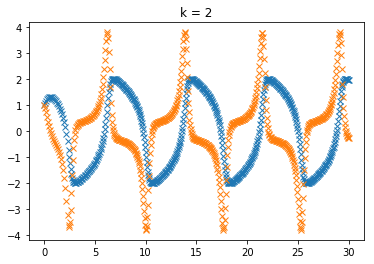

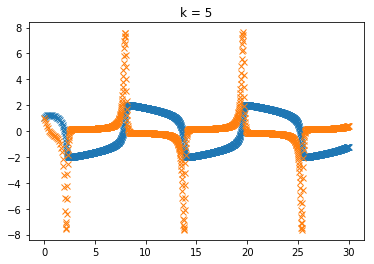

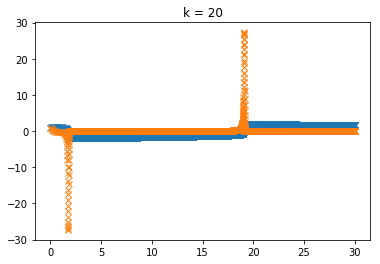

In [5]:
for k in [2,5,20]:
    u0 =  np.array([1.0, 1.0])                   # the initial value
    h  = 0.1                                     # the time step size
    hist,f_eval = adp_RK(u0, RKF(), 30, h, k, 5, 0.00001, True)
######____plotting___#########
    plt.figure()
    times = [t for t,u in hist]
    plt.plot(times, [u for t,u in hist], 'x')
    plt.title("k = " + str(k))

From the results of the higher order test(5th order Runge–Kutta–Fehlberg), compared to the 3rd-order Bogacki-Shampine method, we can see the adaptive control renders the higher order method with relatively "coarse" time discretization. Thus, a faster convergence rate will be achieved.

## Part3: Work-Precision test for nonlinear pronlem

Clearly, the work-precision test needs a relatively accurate solution for measuring the error. Thus,  we use the computation results of the 5th order Runge–Kutta–Fehlberg method with a fine time discretization as $h = 0.001$ as the reference solution. 
<br>

In the test, the performace of the adaptive control applied to the 3rd-order Bogacki-Shampine method will be studied.<br>

In the code, the error estimate functions with or without the adaptive error control are denoted as $\text{error_apt()}$ and $\text{error_wo_apt()}$, respectively. In addition, note that in adaptive control, the time step size $h$ can not be less than the $0.001$, which we have already seen as the fine step size. <br>

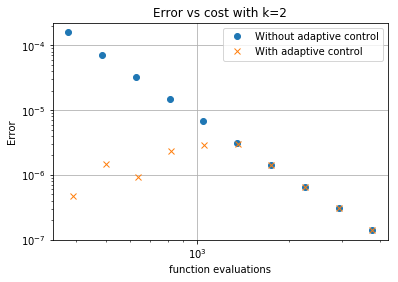

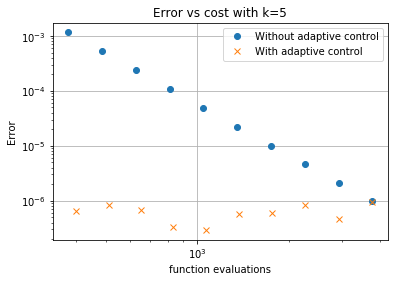

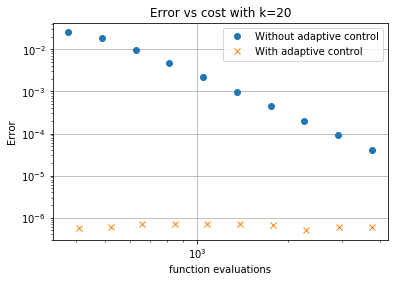

In [6]:
u0 =  np.array([1.0, 1.0])                # the initial value
t_final  = 5
def error_wo_apt(exact, h, k):
    err   = []                           # list for error storage
    hist,f_eval  = adp_RK(u0, BS3_bct(), t_final, h , k, 3, 0.00001, False)        # choose the constant timestep as h=hs
    for j in range(1,len(hist)):
        t = hist[j][0]    #current t
        for jj in range(1,len(exact)):
            if t == round(exact[jj][0],4):
                err.append((LA.norm(exact[jj][1]-hist[j][1],np.inf)))
    return max(err)                                                         # the global error estimate

def error_apt(exact, h, k):
    err_apt   = []                           # list for error storage
    hist,f_eval  = adp_RK(u0, BS3_bct(), t_final, h , k, 3, 0.00001, True)
    for j in range(1,len(hist)):
        t = hist[j][0]    #current t
        for jj in range(1,len(exact)):
            if t == round(exact[jj][0],4):
                err_apt.append((LA.norm(exact[jj][1]-hist[j][1],np.inf)))
    return max(err_apt), f_eval                                            # additional function evaluations returned

for k in [2,5,20]:
    exact,_ = adp_RK(u0, RKF(), t_final, 0.001, k, 5, 0.00001, False)         # the reference exact solution
    hs = np.logspace(-2.4, -1.4, 10)                                          # fixed time steps hs 
    error_BS3_woapt         = [error_wo_apt(exact, hx, k) for hx in hs]
    error_BS3_apt           = [error_apt(exact, hx, k)[0] for hx in hs]   
    f_eval                  = [error_apt(exact, hx, k)[1] for hx in hs]  
    plt.figure()
    plt.loglog(t_final*3/hs, error_BS3_woapt, 'o', label = 'Without adaptive control')
    plt.loglog(t_final*3/hs + f_eval, error_BS3_apt, 'x', label = 'With adaptive control')
    plt.title('Error vs cost with k=' + str(k))
    plt.ylabel('Error')
    plt.xlabel('function evaluations')
    plt.grid()
    plt.legend(loc='upper right');

According to the figures above, we can see for all different values of k, fewer(or relatively equal when $k$=2) function evaluations needed for the adaptive control method in the sense of reaching a specific error bound. Besides, as the coefficient $k$ increases, an adaptive control embedding is even more beneficial. Thus, for the similar nonlinear equations, a fixed time step method could be applied when $k$ is small, while for larger $k$, it is better to implement the adaptive error control.

[1]: Bogacki–Shampine method, Wikipedia, https://en.wikipedia.org/wiki/Bogacki%E2%80%93Shampine_method <br>
[2]: Runge–Kutta–Fehlberg method,Wikipedia, https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method